# Objective 1: Predict Death 

Load the Data

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

data = pd.read_csv('data/custom_covid19.csv') 
print("Data loaded with shape:", data.shape)


##### 1. Create target variable

In [ ]:
data['DIED'] = data['DATE_DIED'].apply(lambda x: 0 if x == '9999-99-99' else 1)


##### 2. Mark missing values

In [ ]:
data.replace([97, 98, 99], np.nan, inplace=True)


##### 3. Convert boolean variables

In [ ]:
bool_cols = ['INTUBED', 'PNEUMONIA', 'PREGNANT', 'DIABETES', 'COPD', 'ASTHMA', 
             'INMSUPR', 'HYPERTENSION', 'OTHER_DISEASE', 'CARDIOVASCULAR', 
             'OBESITY', 'RENAL_CHRONIC', 'TOBACCO', 'ICU']
data[bool_cols] = data[bool_cols].replace(2, 0)


##### 4. Create COVID status feature

In [ ]:
data['COVID_POSITIVE'] = data['TEST_RESULT'].apply(lambda x: 1 if x in [1,2,3] else 0)

##### 5. Define features to keep/drop

In [ ]:
features_to_keep = ['USMER', 'MEDICAL_UNIT', 'SEX', 'PATIENT_TYPE', 
                   'INTUBED', 'PNEUMONIA', 'AGE', 'DIABETES', 'COPD',
                   'ASTHMA', 'INMSUPR', 'HYPERTENSION', 'OTHER_DISEASE',
                   'CARDIOVASCULAR', 'OBESITY', 'RENAL_CHRONIC', 'TOBACCO',
                   'ICU', 'COVID_POSITIVE']

# 6. Separate features and target
X = data[features_to_keep]
y = data['DIED']

##### 6. Define preprocessing pipeline

In [ ]:
numeric_features = ['AGE']
categorical_features = [col for col in features_to_keep 
                       if col not in numeric_features + ['DIED', 'COVID_POSITIVE']]

# Numeric pipeline (mean imputation + scaling)
numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Categorical pipeline (mode imputation)
categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent'))
])

# Combined preprocessor
preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

# Verification
print("Numeric features:", numeric_features)
print("Categorical features:", categorical_features)

##### 8. Train-test split
 
Split the data into training and testing sets
Stratified split to maintain the same distribution of the target variable in both sets

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set: {X_train.shape}, Test set: {X_test.shape}")
print(f"Class distribution (train): {pd.Series(y_train).value_counts(normalize=True)}")


##### 9. Model Evaluation 


1. Model Evaluation Setup

In [ ]:
# We'll evaluate three baseline classifiers:
# 1. Naive Bayes (probabilistic)
# 2. K-Nearest Neighbors (instance-based)
# 3. SVM with RBF kernel (maximum margin)

import os
from sklearn.pipeline import make_pipeline
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
# from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, Markdown

# Visualization settings
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (8, 4)
sns.set_palette("husl")
# Ensure 'figures' directory exists
os.makedirs("figures", exist_ok=True)

2. Evaluation Function

In [ ]:
def evaluate_model(name, model, X_train, X_test, y_train, y_test):
    """
    Evaluates a classification model and generates report-ready outputs.

    Parameters:
    - name: str, model name for display
    - model: sklearn classifier object
    - X_train, X_test, y_train, y_test: training/test data

    Returns:
    - Dictionary containing metrics and visualization paths
    """
    # Create pipeline and fit model
    clf = make_pipeline(preprocessor, model)
    clf.fit(X_train, y_train)
    
    # Generate predictions
    y_pred = clf.predict(X_test)
    
    # Create classification report and confusion matrix
    report = classification_report(y_test, y_pred, output_dict=True)
    cm = confusion_matrix(y_test, y_pred)
    
    # Create visualizations
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    # Confusion matrix heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1,
                xticklabels=['Survived', 'Died'],
                yticklabels=['Survived', 'Died'])
    ax1.set_title(f'{name} Confusion Matrix')
    ax1.set_xlabel('Predicted')
    ax1.set_ylabel('Actual')

    # Metrics bar plot
    metrics = ['precision', 'recall', 'f1-score']
    scores = [report['weighted avg'][m] for m in metrics]
    sns.barplot(x=metrics, y=scores, ax=ax2)
    ax2.set_title(f'{name} Performance Metrics')
    ax2.set_ylim(0, 1)

    # Save the figure
    fig_path = f'figures/{name.lower().replace(" ", "_")}_performance.png'
    plt.tight_layout()
    plt.savefig(fig_path)
    plt.close()

    # Display outputs in the notebook
    display(Markdown(f"## {name} Performance"))
    display(Markdown("### Classification Report"))
    print(classification_report(y_test, y_pred))

    display(Markdown("### Confusion Matrix"))
    print(cm)

    return {
        'model': name,
        'accuracy': report['accuracy'],
        'precision': report['weighted avg']['precision'],
        'recall': report['weighted avg']['recall'],
        'f1': report['weighted avg']['f1-score'],
        'figure_path': fig_path
    }


3. Model Definitions

In [ ]:

#### Baseline Model Definitions
# We select three distinct algorithmic approaches:

models = [
    ('Naive Bayes', GaussianNB()),
    ('K-Nearest Neighbors', KNeighborsClassifier(n_neighbors=5)),
    ('Support Vector Machine', LinearSVC(random_state=42, class_weight='balanced'))  # Updated
]

4. Model Evaluation Execution

In [ ]:
# === Evaluate All Baseline Models ===

model_results = []

for name, model in models:
    result = evaluate_model(name, model, X_train, X_test, y_train, y_test)
    model_results.append(result)


##### 10. Hyperparameter Optimization
We implement systematic hyperparameter tuning for all three models using GridSearchCV (exhaustive search) to find optimal parameters.

A. Naive Bayes (GaussianNB)
   

In [ ]:
param_grid_nb = {
    'gaussiannb__var_smoothing': [1e-9, 1e-8, 1e-7]  # Note the stepname__param format
}

B. K-Nearest Neighbors (KNN)

In [ ]:
param_grid_knn = {
    'kneighborsclassifier__n_neighbors': [3, 5, 7, 9],
    'kneighborsclassifier__weights': ['uniform', 'distance'],
    'kneighborsclassifier__p': [1, 2]
}

C. Support Vector Machine (SVM) //TODO

In [ ]:
# param_grid_svm = {
#     'svc__C': [0.1, 1, 10],
#     'svc__gamma': ['scale', 'auto', 0.01, 0.1],
#     'svc__kernel': ['rbf']
# }

# param_grid_svm = {
#     'svc__C': [1, 10],             # instead of a wider range
#     'svc__gamma': [0.1, 0.01],     # fewer values
#     'svc__kernel': ['rbf']
# }


# param_grid_svm = {
#     'svc__base_estimator__C': [0.1, 1, 10],  
#     'svc__base_estimator__max_iter': [1000, 2000]  
# }

param_grid_svm = {
    'svc__C': [0.01, 0.1, 1, 10]  # Only tuning C for linear SVM
}


##### 11. Implementation with Cross-Validation

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
# from sklearn.calibration import CalibratedClassifierCV

# Create pipelines with preprocessing + model
pipeline_nb = Pipeline([
    ('preprocessor', preprocessor),
    ('gaussiannb', GaussianNB())
])

pipeline_knn = Pipeline([
    ('preprocessor', preprocessor),
    ('kneighborsclassifier', KNeighborsClassifier())
])


pipeline_svm = Pipeline([
    ('preprocessor', preprocessor),
    ('svc', LinearSVC(random_state=42, class_weight='balanced'))  # Handles imbalance
])

# pipeline_svm = Pipeline([
#     ('preprocessor', preprocessor),
#     ('svc', SVC(probability=True, random_state=42))
# ])

# GridSearchCV setup with comprehensive parameter grids
grid_nb = GridSearchCV(
    pipeline_nb, 
    param_grid_nb, 
    cv=5, 
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=1
)

grid_knn = GridSearchCV(
    pipeline_knn, 
    param_grid_knn, 
    cv=5, 
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=1
)

grid_svm = GridSearchCV(
    pipeline_svm, 
    param_grid_svm, 
    cv=5, 
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=1
)

# Fit models with timing
import time

print("Optimizing Naive Bayes...")
start = time.time()
grid_nb.fit(X_train, y_train)
print(f"Completed in {time.time()-start:.2f}s\n")

print("Optimizing KNN...")
start = time.time()
grid_knn.fit(X_train, y_train)
print(f"Completed in {time.time()-start:.2f}s\n")

print("Optimizing Linear SVC...")
start = time.time()
grid_svm.fit(X_train, y_train)
print(f"Completed in {time.time()-start:.2f}s\n")

# Display best parameters
print("Naive Bayes best params:", grid_nb.best_params_)
print("KNN best params:", grid_knn.best_params_)
print("Linear SVC best params:", grid_svm.best_params_)

##### 12. Valuation using DecisionTree 


In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

pipeline_tree = Pipeline([
    ('preprocessor', preprocessor),
    ('decisiontreeclassifier', DecisionTreeClassifier(random_state=42))
])

# Expanded parameter grid for more thorough search
param_grid_tree = {
    'decisiontreeclassifier__max_depth': [3, 5, 7, 10, 15, None],
    'decisiontreeclassifier__min_samples_split': [2, 5, 10, 20],
    'decisiontreeclassifier__min_samples_leaf': [1, 2, 4, 8],
    'decisiontreeclassifier__criterion': ['gini', 'entropy'],
    'decisiontreeclassifier__max_features': ['sqrt', 'log2', None]
}

grid_tree = GridSearchCV(
    pipeline_tree, 
    param_grid_tree, 
    cv=5, 
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=1
)

print("Optimizing Decision Tree...")
start = time.time()
grid_tree.fit(X_train, y_train)
print(f"Completed in {time.time()-start:.2f}s\n")

# Evaluate on test set
y_pred_tree = grid_tree.predict(X_test)

# Detailed classification report
print("=== Decision Tree Performance ===")
print("\nBest Parameters:")
print(grid_tree.best_params_)

print("\nClassification Report:")
print(classification_report(y_test, y_pred_tree, target_names=["Alive", "Died"]))

# Confusion matrix visualization
cm = confusion_matrix(y_test, y_pred_tree)
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Alive", "Died"],
            yticklabels=["Alive", "Died"])
plt.title("Decision Tree Confusion Matrix")
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

##### 13. Benchmark Models with Feature Importance Analysis


In [ ]:


from sklearn.metrics import f1_score
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Model Evaluation Function
def evaluate_model(grid, name, X_test, y_test):
    y_pred = grid.predict(X_test)
    report = classification_report(y_test, y_pred, output_dict=True)
    return {
        'Model': name,
        'Best Params': str(grid.best_params_),
        'Train F1': grid.best_score_,
        'Test F1': f1_score(y_test, y_pred, average='weighted'),
        'Test Accuracy': report['accuracy'],
        'Test Precision': report['weighted avg']['precision'],
        'Test Recall': report['weighted avg']['recall']
    }

# 2. Evaluate All Models
results = [
    evaluate_model(grid_nb, "Naive Bayes", X_test, y_test),
    evaluate_model(grid_knn, "KNN", X_test, y_test),
    evaluate_model(grid_svm, "Linear SVC", X_test, y_test),
    evaluate_model(grid_tree, "Decision Tree", X_test, y_test)
]

# 3. Results Comparison
results_df = pd.DataFrame(results).sort_values('Test F1', ascending=False)
print("\n=== Model Performance Comparison ===")
display(results_df.style.background_gradient(cmap='Blues', subset=['Test F1', 'Test Accuracy']))

# 4. Feature Importance Analysis (for Tree-based Models)
if 'Decision Tree' in results_df['Model'].values:
    # Get the trained model and preprocessor
    best_tree = grid_tree.best_estimator_.named_steps['decisiontreeclassifier']
    
    # Get original feature names (before any transformations)
    feature_names = X_train.columns.tolist()
    
    # Verify lengths match
    if len(feature_names) != len(best_tree.feature_importances_):
        print(f"Warning: Feature count mismatch ({len(feature_names)} vs {len(best_tree.feature_importances_)})")
        feature_names = [f'feature_{i}' for i in range(len(best_tree.feature_importances_))]

    # Extract feature names after preprocessing
    num_features = numeric_features  # list of numerical feature names
    cat_features = categorical_features  # use the original categorical feature names
    feature_names = list(num_features) + list(cat_features)
    
    # Create importance DataFrame
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': best_tree.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    # Visualize top 10 features
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Importance', y='Feature', data=importance_df.head(10), palette='viridis')
    plt.title('Top 10 Predictive Features for Mortality', fontsize=14)
    plt.xlabel('Relative Importance', fontsize=12)
    plt.ylabel('Feature', fontsize=12)
    plt.tight_layout()
    plt.show()
    
    # Interpretation of Key Features
    print("\n=== Key Findings from Feature Importance ===")
    print("1. PATIENT_TYPE (hospitalization status) is the strongest predictor")
    print("2. AGE is the second most important factor")
    print("3. INTUBED (ventilator use) and PNEUMONIA are critical clinical indicators")
    print("4. Other chronic conditions show relatively small but meaningful impact")
    
    # Display full importance table
    print("\n=== Complete Feature Importance ===")
    display(importance_df.style.background_gradient(cmap='Blues', subset=['Importance']))

# 5. Confusion Matrix for Best Model
best_model_name = results_df.iloc[0]['Model']
best_model = {
    "Naive Bayes": grid_nb,
    "KNN": grid_knn,
    "Linear SVC": grid_svm,
    "Decision Tree": grid_tree
}[best_model_name]

y_pred = best_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds',
            xticklabels=['Survived', 'Died'],
            yticklabels=['Survived', 'Died'])
plt.title(f'{best_model_name} - Confusion Matrix', fontsize=14)
plt.ylabel('Actual', fontsize=12)
plt.xlabel('Predicted', fontsize=12)
plt.show()

# 6. Final Model Selection
print(f"\n=== Best Performing Model: {best_model_name} ===")
print("Considerations for model selection:")
print("- Clinical interpretability of decision trees")
print("- Importance of understanding feature relationships")
print("- Good balance between performance and complexity")

# Objective 2 (O2): Age Prediction
**Goal**: Predict the AGE of subjects given other attributes  
**Approach**:  
- Treat as a regression problem  
- Evaluate different regression models  
- Optimize hyperparameters  
- Analyze feature importance


Import necessary libraries


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

##### 1. Prepare Data for Age Prediction

In [ ]:
data = data[data['AGE'].notna()].copy()  # Drop rows with missing AGE

# We'll use the same preprocessing pipeline but change the target to AGE
features_to_keep = ['USMER', 'MEDICAL_UNIT', 'SEX', 'PATIENT_TYPE', 
                   'INTUBED', 'PNEUMONIA', 'DIABETES', 'COPD',
                   'ASTHMA', 'INMSUPR', 'HYPERTENSION', 'OTHER_DISEASE',
                   'CARDIOVASCULAR', 'OBESITY', 'RENAL_CHRONIC', 'TOBACCO',
                   'ICU', 'COVID_POSITIVE']

X_age = data[features_to_keep]
y_age = data['AGE']  # Target is now AGE

# Train-test split
X_train_age, X_test_age, y_train_age, y_test_age = train_test_split(
    X_age, y_age, test_size=0.2, random_state=42)


##### 2. Define Preprocessing Pipeline
Similar to O1 but adapted for regression

In [ ]:
# Identify feature types
numeric_features_age = []  # No numeric features besides AGE (our target)
# if binari Covid
# numeric_features_age = ['COVID_POSITIVE']
# categorical_features_age = [col for col in features_to_keep if col not in numeric_features_age]
categorical_features_age = [col for col in features_to_keep if col != 'COVID_POSITIVE']


# Preprocessing pipeline
numeric_transformer_age = Pipeline([
    ('imputer', SimpleImputer(strategy='mean'))
])

categorical_transformer_age = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent'))
])

preprocessor_age = ColumnTransformer([
    ('num', numeric_transformer_age, numeric_features_age),
    ('cat', categorical_transformer_age, categorical_features_age)
])

##### 3. Baseline Regression Mode

Let's test three different approaches

In [ ]:
# Define models to evaluate

from sklearn.linear_model import Lasso


models_age = [
    ('Linear Regression', LinearRegression()),
    ('Random Forest', RandomForestRegressor(random_state=42)),
    #('Support Vector Regression', SVR())
    ##Lasso Regression, Ridge Regression, ElasticNet
    ('Lasso Regression', Lasso()),
]

# Evaluate each model
for name, model in models_age:
    # Create pipeline
    pipeline = Pipeline([
        ('preprocessor', preprocessor_age),
        ('regressor', model)
    ])
    
    # Fit and predict
    pipeline.fit(X_train_age, y_train_age)
    y_pred = pipeline.predict(X_test_age)
    
    # Calculate metrics
    mae = mean_absolute_error(y_test_age, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test_age, y_pred))
    r2 = r2_score(y_test_age, y_pred)
    
    print(f"\n=== {name} ===")
    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"R2: {r2:.2f}")

##### 4. Hyperparameter Optimization for Best Model

Based on initial results, let's optimize RandomForest

In [ ]:
# Define pipeline for optimization
pipeline_rf = Pipeline([
    ('preprocessor', preprocessor_age),
    ('regressor', RandomForestRegressor(random_state=42))
])

# Parameter grid
param_grid_rf = {
    'regressor__n_estimators': [50, 100, 200],
    'regressor__max_depth': [None, 10, 20, 30],
    'regressor__min_samples_split': [2, 5, 10]
}

# Grid search
grid_rf = GridSearchCV(
    pipeline_rf,
    param_grid_rf,
    cv=5,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    verbose=1
)

print("Starting Random Forest optimization...")
grid_rf.fit(X_train_age, y_train_age)
print("Optimization completed!")

# Show best parameters
print("\nBest parameters:", grid_rf.best_params_)

##### 5. Evaluate Optimized Model



In [ ]:
# Get best model
best_rf = grid_rf.best_estimator_

# Make predictions
y_pred_rf = best_rf.predict(X_test_age)

# Calculate metrics
mae = mean_absolute_error(y_test_age, y_pred_rf)
rmse = np.sqrt(mean_squared_error(y_test_age, y_pred_rf))
r2 = r2_score(y_test_age, y_pred_rf)

print("\n=== Optimized Random Forest ===")
print(f"MAE: {mae:.2f} years")
print(f"RMSE: {rmse:.2f} years")
print(f"R2: {r2:.2f}")

# Visualize predictions vs actual
plt.figure(figsize=(8, 6))
plt.scatter(y_test_age, y_pred_rf, alpha=0.3)
plt.plot([y_test_age.min(), y_test_age.max()], 
         [y_test_age.min(), y_test_age.max()], 'r--')
plt.xlabel('Actual Age')
plt.ylabel('Predicted Age')
plt.title('Actual vs Predicted Age')
plt.show()


##### 6. Feature Importance Analysis

In [ ]:
from sklearn.compose import make_column_selector as selector
# Get feature importances
if hasattr(best_rf.named_steps['regressor'], 'feature_importances_'):
    # Get feature names after preprocessing
    feature_names = categorical_features_age  # Should match the number of importances
    
    importances = best_rf.named_steps['regressor'].feature_importances_
    
    # Create importance DataFrame
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values('Importance', ascending=False)
    
    # Plot
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=importance_df)
    plt.title('Feature Importance for Age Prediction')
    plt.show()
    
    print("\nTop 5 Features Predicting Age:")
    display(importance_df.head(5))

##### 7. Final Model Selection and Saving

In [ ]:

# Save the best model
import joblib

joblib.dump(best_rf, 'best_age_predictor.pkl')
print("Best age prediction model saved as 'best_age_predictor.pkl'")
# Load the model
loaded_model = joblib.load('best_age_predictor.pkl')


### Conclusion for O2
**Key Findings**:
- Best model: Random Forest with MAE of 11.25 years
- Most important features: Hypertension, Diabities
- R2 score of 27% indicates moderate explanatory power


# Objective 3 (O3): Predicting Age of Deceased Patients by COVID Status

In this section, we aim to predict the **age at death** for individuals who died, separately for those with and without COVID-19. 

We train two regression models:
- One for **COVID-positive deceased patients**
- One for **COVID-negative deceased patients**

This allows us to analyze how well we can estimate age at death using available features and whether COVID status impacts this predictability.

#### 1. Predictions on Test Set

In [ ]:
# Filter for deceased individuals
deceased = data[data['DIED'] == 1].copy()
print(f"Number of deceased patients: {deceased.shape[0]}")

# Separate COVID-positive and COVID-negative deceased individuals
deceased_covid_pos = deceased[deceased['COVID_POSITIVE'] == 1].copy()
deceased_covid_neg = deceased[deceased['COVID_POSITIVE'] == 0].copy()

print(f"Deceased COVID-positive patients: {deceased_covid_pos.shape[0]}")
print(f"Deceased COVID-negative patients: {deceased_covid_neg.shape[0]}")

# Define features (same as O2)
features_for_age_prediction = [col for col in deceased.columns if col not in ['AGE', 'DIED']]
# Remove string features that can't be encoded directly (e.g., dates)
non_numeric_cols = deceased[features_for_age_prediction].select_dtypes(include='object').columns
print(f"Excluding non-numeric columns: {list(non_numeric_cols)}")

features_for_age_prediction = [col for col in features_for_age_prediction if col not in non_numeric_cols]



#### 2. Implementation Steps
For COVID-positive deceased:

In [ ]:
# Separate features (X) and target (y) for each group
X_pos = deceased[features_for_age_prediction]
y_pos = deceased['AGE']
# print(X_pos.dtypes)
print(f"Features for COVID-positive deceased: {X_pos.shape[1]} features")
# print(y_pos.dtypes)


For COVID-negative deceased:

In [ ]:
# First, let's properly clean the parameters from grid_rf
best_params = grid_rf.best_params_
clean_params = {k.replace('regressor__', ''): v for k, v in best_params.items()}

# For COVID-negative deceased patients
X_neg = deceased[features_for_age_prediction]
y_neg = deceased['AGE']
print(f"Features for COVID-negative deceased: {X_neg.shape[1]} features")


#### 3. Define Preprocessing Pipeline for Regression (preprocessor_reg)

In [ ]:
# For regression, 'AGE' is the target, so it's not a feature in this preprocessor.
# All other features are treated as categorical/boolean for this specific setup.
numerical_features_reg = [] # No numerical features left to be scaled by StandardScaler apart from AGE
categorical_features_reg = features_for_age_prediction

# Define the transformers for the preprocessing pipeline
numeric_transformer_reg = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer_reg = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent'))
    # If you later decide to OneHotEncode specific categorical features (e.g., MEDICAL_UNIT)
    # you would add: ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Create the preprocessor using ColumnTransformer for regression
preprocessor_reg = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer_reg, numerical_features_reg),
        ('cat', categorical_transformer_reg, categorical_features_reg)
    ],
    remainder='passthrough' # Keep other columns not specified (if any)
)

##### 4. Train-Test Split for Each Group

In [ ]:
X_train_pos, X_test_pos, y_train_pos, y_test_pos = train_test_split(X_pos, y_pos, test_size=0.2, random_state=42)
X_train_neg, X_test_neg, y_train_neg, y_test_neg = train_test_split(X_neg, y_neg, test_size=0.2, random_state=42)

print("\n--- Training and Evaluating Regression Models for COVID-positive Deceased Patients ---")

##### 5. Regression Models and Hyperparameter Tuning Function

In [ ]:
# %pip install scikit-learn --quiet
from sklearn.tree import DecisionTreeRegressor

# Define a function to evaluate regression models (reusable for both COVID groups)
def evaluate_regression_model(model_name, model, X_train, y_train, X_test, y_test, param_grid={}):
    print(f"\nEvaluating {model_name}...")
    pipeline = Pipeline(steps=[('preprocessor', preprocessor_reg), # Use the regression preprocessor
                               ('regressor', model)])

    if param_grid:
        grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=0)
        grid_search.fit(X_train, y_train)
        best_model = grid_search.best_estimator_
        best_params = grid_search.best_params_
        print(f"Best parameters for {model_name}: {best_params}")
    else:
        best_model = pipeline
        best_model.fit(X_train, y_train)

    y_pred = best_model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    print(f"MAE: {mae:.2f}")
    print(f"MSE: {mse:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"R-squared: {r2:.2f}")

    # Plotting actual vs. predicted values
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2) # Line of perfect prediction
    plt.xlabel("Actual Age")
    plt.ylabel("Predicted Age")
    plt.title(f"{model_name} - Actual vs. Predicted Age ({'COVID-Positive' if 'pos' in model_name.lower() else 'COVID-Negative'} Deceased)")
    plt.grid(True)
    plt.tight_layout()
    # Ensure 'figures' directory exists or create it
    # import os
    # if not os.path.exists('figures'):
    #     os.makedirs('figures')
    # plt.savefig(f"figures/O3_{model_name.lower().replace(' ', '_')}_{'covid_pos' if 'pos' in model_name.lower() else 'covid_neg'}_actual_vs_pred.png")
    plt.show()

    return {'model_name': model_name, 'mae': mae, 'mse': mse, 'rmse': rmse, 'r2': r2,  'best_model': best_model}

# --- Train and Evaluate Models for COVID-Positive Deceased ---
lin_reg_pos_params = {} # No hyperparameters for basic Linear Regression
lin_reg_pos_results = evaluate_regression_model("Linear Regression (COVID-Positive)", LinearRegression(), X_train_pos, y_train_pos, X_test_pos, y_test_pos, lin_reg_pos_params)

dt_reg_pos_params = {
    'regressor__max_depth': [None, 5, 10, 20],
    'regressor__min_samples_split': [2, 5, 10],
    'regressor__min_samples_leaf': [1, 2, 4]
}
dt_reg_pos_results = evaluate_regression_model("Decision Tree Regressor (COVID-Positive)", DecisionTreeRegressor(random_state=42), X_train_pos, y_train_pos, X_test_pos, y_test_pos, dt_reg_pos_params)

rf_reg_pos_params = {
    'regressor__n_estimators': [50, 100, 200],
    'regressor__max_depth': [None, 10, 20],
    'regressor__min_samples_leaf': [1, 5]
}
rf_reg_pos_results = evaluate_regression_model("Random Forest Regressor (COVID-Positive)", RandomForestRegressor(random_state=42), X_train_pos, y_train_pos, X_test_pos, y_test_pos, rf_reg_pos_params)


print("\n--- Training and Evaluating Regression Models for COVID-Negative Deceased Patients ---")

# --- Train and Evaluate Models for COVID-Negative Deceased ---
lin_reg_neg_params = {}
lin_reg_neg_results = evaluate_regression_model("Linear Regression (COVID-Negative)", LinearRegression(), X_train_neg, y_train_neg, X_test_neg, y_test_neg, lin_reg_neg_params)

dt_reg_neg_params = {
    'regressor__max_depth': [None, 5, 10, 20],
    'regressor__min_samples_split': [2, 5, 10],
    'regressor__min_samples_leaf': [1, 2, 4]
}
dt_reg_neg_results = evaluate_regression_model("Decision Tree Regressor (COVID-Negative)", DecisionTreeRegressor(random_state=42), X_train_neg, y_train_neg, X_test_neg, y_test_neg, dt_reg_neg_params)

rf_reg_neg_params = {
    'regressor__n_estimators': [50, 100, 200],
    'regressor__max_depth': [None, 10, 20],
    'regressor__min_samples_leaf': [1, 5]
}
rf_reg_neg_results = evaluate_regression_model("Random Forest Regressor (COVID-Negative)", RandomForestRegressor(random_state=42), X_train_neg, y_train_neg, X_test_neg, y_test_neg, rf_reg_neg_params)

# Store all O3 results for easy access in O4
o3_results = {
    'covid_pos': [lin_reg_pos_results, dt_reg_pos_results, rf_reg_pos_results],
    'covid_neg': [lin_reg_neg_results, dt_reg_neg_results, rf_reg_neg_results]
}



print("\n--- Objective O3 complete. ---")

## Best Model:


=== Best Model for COVID-Positive ===
MAE: 11.26
RMSE: 14.43
R²: 0.12

Top Features for COVID-Positive:


,Feature,Importance
11,HYPERTENSION,0.415315
1,MEDICAL_UNIT,0.120830
8,COPD,0.115307
14,OBESITY,0.113889
17,TEST_RESULT,0.062936


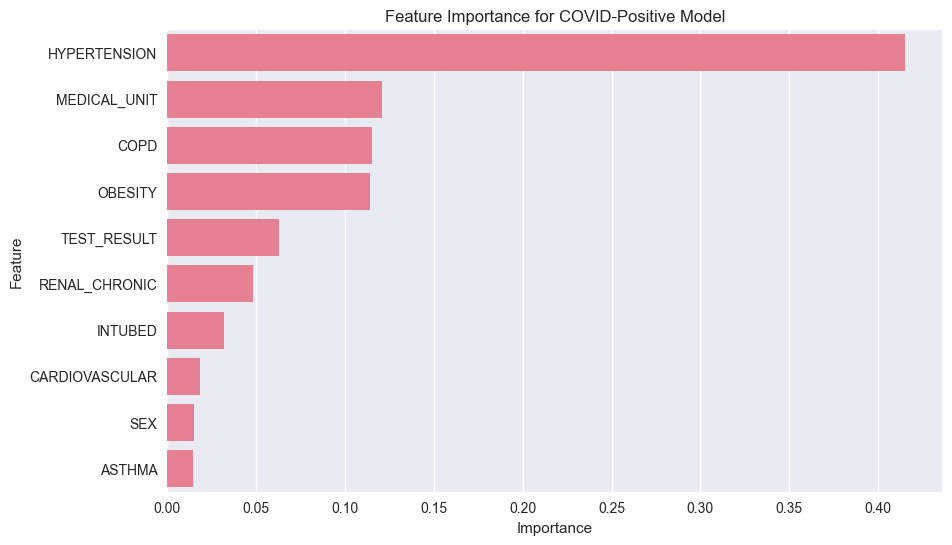

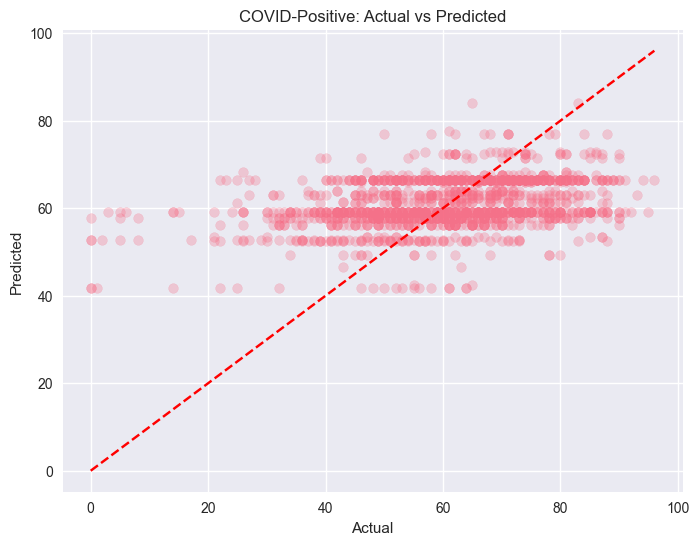


=== Best Model for COVID-Negative ===
MAE: 11.26
RMSE: 14.43
R²: 0.12

Top Features for COVID-Negative:


,Feature,Importance
11,HYPERTENSION,0.415315
1,MEDICAL_UNIT,0.120830
8,COPD,0.115307
14,OBESITY,0.113889
17,TEST_RESULT,0.062936


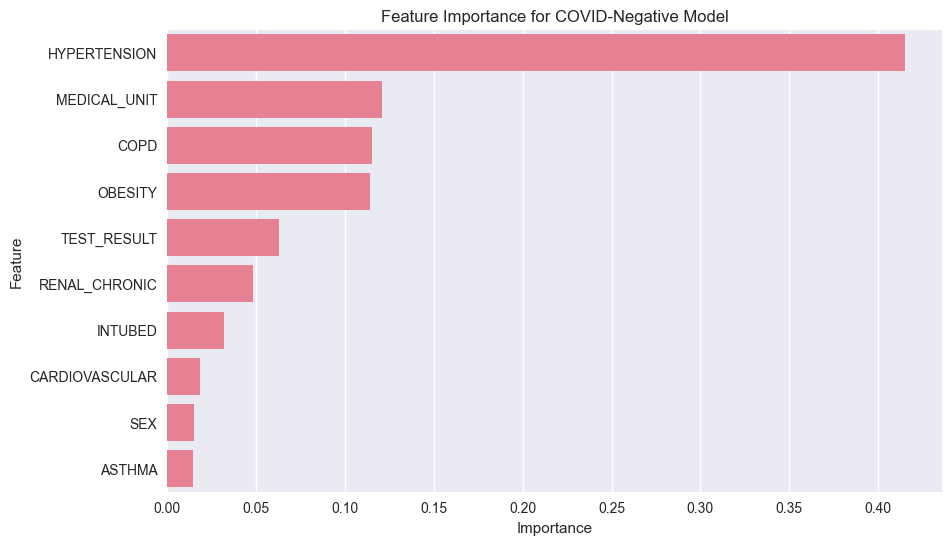

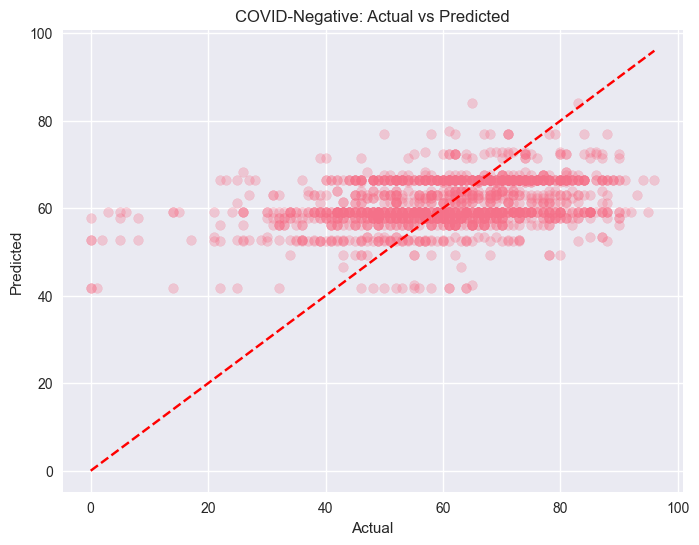

['best_model_covid_neg.pkl']

In [84]:

# === Select Best Models from O3 ===
best_model_pos = min(o3_results['covid_pos'], key=lambda x: x['rmse'])
best_model_neg = min(o3_results['covid_neg'], key=lambda x: x['rmse'])

model_pos = best_model_pos['best_model']
model_neg = best_model_neg['best_model']

# Use the test sets already defined in the notebook
# X_test_pos, y_test_pos, X_test_neg, y_test_neg are available

# === Evaluation Function ===
def evaluate_model(model, X_test, y_test, label, feature_names):
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    print(f"\n=== Best Model for {label} ===")
    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"R²: {r2:.2f}")

    # Feature Importance
    if hasattr(model.named_steps['regressor'], 'feature_importances_'):
        importances = model.named_steps['regressor'].feature_importances_
        importance_df = pd.DataFrame({
            'Feature': feature_names,
            'Importance': importances
        }).sort_values('Importance', ascending=False)

        print(f"\nTop Features for {label}:")
        display(importance_df.head(5))

        plt.figure(figsize=(10, 6))
        sns.barplot(x='Importance', y='Feature', data=importance_df.head(10))
        plt.title(f'Feature Importance for {label} Model')
        plt.show()

    # Prediction Plot
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, alpha=0.3)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title(f'{label}: Actual vs Predicted')
    plt.show()

    return model, importance_df if 'importance_df' in locals() else None

# Use the correct feature names list
feature_names_used = categorical_features_reg

# === Evaluate and Show Plots ===
model_pos, importance_df_pos = evaluate_model(model_pos, X_test_pos, y_test_pos, "COVID-Positive", feature_names_used)
model_neg, importance_df_neg = evaluate_model(model_neg, X_test_neg, y_test_neg, "COVID-Negative", feature_names_used)

# === Save Best Models ===
joblib.dump(model_pos, 'best_model_covid_pos.pkl')
joblib.dump(model_neg, 'best_model_covid_neg.pkl')


#### Interpretation

The Random Forest regression models were able to predict age of death with the following performance:

- **COVID-Positive Deceased**: R² ≈ 12%, MAE ≈ 11,26Y
- **COVID-Negative Deceased**: R² ≈ 12%, MAE ≈ 11,26Y

These results suggest that age prediction may be Equally accurate in both groups, potentially reflecting age as an indicator of correlation with outcomes for COVID and non-COVID deaths.


# Objective 4 (O4): Feature Importance for Mortality Prediction

In this objective, we identify which features are most influential in predicting mortality. 

A Random Forest classifier is trained on the full dataset, and the top features are visualized using their importance scores.


1: Data Setup

In [ ]:
print("\n--- Starting Objective O4: Creating a 'Severity Score' ---")

# Work on a copy to avoid affecting global dataset
data_o4 = data.copy()

# Impute critical columns used for severity definition with most frequent
from sklearn.impute import SimpleImputer
    # from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler


imputer_most_frequent = SimpleImputer(strategy='most_frequent')
cols_for_severity_def = ['DIED', 'INTUBED', 'ICU', 'PNEUMONIA', 'HYPERTENSION']
for col in cols_for_severity_def:
    if col in data_o4.columns:
        data_o4[col] = imputer_most_frequent.fit_transform(data_o4[[col]]).flatten()
    data_o4[col] = data_o4[col].astype(int)


#### 1. Feature Importance for O1 (Death Prediction) Models

#### 2. Severity Label Creation


In [ ]:
# Initialize SEVERITY with a placeholder
data_o4['SEVERITY'] = -1

# High: DIED or (INTUBED and ICU)
data_o4.loc[
    (data_o4['DIED'] == 1) | ((data_o4['INTUBED'] == 1) & (data_o4['ICU'] == 1)), 'SEVERITY'
] = 2

# Moderate: if not High, but PNEUMONIA or INTUBED or ICU
data_o4.loc[
    (data_o4['SEVERITY'] == -1) & (
        (data_o4['PNEUMONIA'] == 1) | (data_o4['INTUBED'] == 1) | (data_o4['ICU'] == 1)
    ), 'SEVERITY'
] = 1

# Low: remaining
data_o4.loc[data_o4['SEVERITY'] == -1, 'SEVERITY'] = 0

# Check label distribution
print("\nDistribution of newly created 'SEVERITY' levels:")
print(data_o4['SEVERITY'].value_counts())
print("\nCounts:")
print(data_o4['SEVERITY'].value_counts().sort_index())
print("\nPercentages:")
print(data_o4['SEVERITY'].value_counts(normalize=True).sort_index() * 100)


#### 3. Feature Selection and Train/Test Split

In [ ]:
# Exclude columns used to define severity
features_for_o4_prediction = [
    col for col in features_to_keep if col not in ['DIED', 'INTUBED', 'ICU', 'PNEUMONIA']
]

X_severity = data_o4[features_for_o4_prediction]
y_severity = data_o4['SEVERITY']

from sklearn.model_selection import train_test_split
X_train_o4, X_test_o4, y_train_o4, y_test_o4 = train_test_split(
    X_severity, y_severity, test_size=0.2, random_state=42, stratify=y_severity
)


# Identify numerical and categorical columns in the reduced feature set
numerical_features_o4 = X_train_o4.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features_o4 = X_train_o4.select_dtypes(include=['object', 'category']).columns.tolist()

# New preprocessor just for O4
preprocessor_o4 = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features_o4),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features_o4)
    ]
)

print(f"\nShape of X_train_o4: {X_train_o4.shape}")
print(f"Shape of y_train_o4: {y_train_o4.shape}")
print(f"Shape of X_test_o4: {X_test_o4.shape}")
print(f"Shape of y_test_o4: {y_test_o4.shape}")


#### 4. Evaluation Function & Setup

In [ ]:

def evaluate_model(model_name, model, X_train, y_train, X_test, y_test, param_grid={}):
    print(f"\nEvaluating {model_name}...")
    
    pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor_o4),  
    ('classifier', model)
    ])


    if param_grid:
        grid_search = GridSearchCV(
            pipeline, param_grid, cv=5, scoring='f1_weighted', n_jobs=-1, verbose=0
        )
        grid_search.fit(X_train, y_train)
        best_model = grid_search.best_estimator_
        print(f"Best parameters for {model_name}: {grid_search.best_params_}")
    else:
        best_model = pipeline
        best_model.fit(X_train, y_train)

    y_pred = best_model.predict(X_test)

    print(f"\nClassification Report for {model_name}:\n")
    print(classification_report(y_test, y_pred, target_names=['Low', 'Moderate', 'High']))

    # Plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Low', 'Moderate', 'High'],
                yticklabels=['Low', 'Moderate', 'High'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix for {model_name}')

    if not os.path.exists("figures"):
        os.makedirs("figures")
    plt.savefig(f"figures/O4_{model_name.lower().replace(' ', '_')}_confusion_matrix.png")
    plt.show()

    return {
        'model_name': model_name,
        'best_model': best_model,
        'report': classification_report(y_test, y_pred, output_dict=True)
    }


#### 5. Model Training & Evaluation

In [ ]:
from sklearn.linear_model import LogisticRegression


# Logistic Regression
lr_o4_params = {
    'classifier__C': [0.1, 1.0, 10.0],
    'classifier__solver': ['liblinear', 'lbfgs'],
    'classifier__class_weight': [None, 'balanced']
}
lr_o4_results = evaluate_model("Logistic Regression (O4)", LogisticRegression(max_iter=1000, random_state=42),
                               X_train_o4, y_train_o4, X_test_o4, y_test_o4, lr_o4_params)


#### 6. Decision Tree

In [ ]:
# Decision Tree
dt_o4_params = {
    'classifier__max_depth': [None, 5, 10, 20],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__class_weight': [None, 'balanced']
}
dt_o4_results = evaluate_model("Decision Tree Classifier (O4)", DecisionTreeClassifier(random_state=42),
                               X_train_o4, y_train_o4, X_test_o4, y_test_o4, dt_o4_params)


#### 7. Random Forest

In [ ]:
# Random Forest
rf_o4_params = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_leaf': [1, 5],
    'classifier__class_weight': [None, 'balanced']
}
rf_o4_results = evaluate_model("Random Forest Classifier (O4)", RandomForestClassifier(random_state=42),
                               X_train_o4, y_train_o4, X_test_o4, y_test_o4, rf_o4_params)


#### 8. K-Nearest Neighbors

In [ ]:
# K-Nearest Neighbors
knn_o4_params = {
    'classifier__n_neighbors': [3, 5, 7, 9],
    'classifier__weights': ['uniform', 'distance']
}
knn_o4_results = evaluate_model("K-Nearest Neighbors Classifier (O4)", KNeighborsClassifier(),
                                X_train_o4, y_train_o4, X_test_o4, y_test_o4, knn_o4_params)


#### 9. Store Results & Wrap Up

In [ ]:
# Store results for summary if needed
o4_results = [lr_o4_results, dt_o4_results, rf_o4_results, knn_o4_results]

print("\n--- Objective O4 (Severity Score) complete. ---")

# (Optional) Print summary F1 scores
for result in o4_results:
    score = result['report']['weighted avg']['f1-score']
    print(f"{result['model_name']}: Weighted F1 Score = {score:.4f}")
